In [2]:
import numpy as np
import matplotlib.pyplot as plt
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"start_date": "2024-01-01",
	"end_date": "2024-12-31",
	"daily": ["temperature_2m_mean", "temperature_2m_max", "temperature_2m_min", "apparent_temperature_mean", "apparent_temperature_max", "apparent_temperature_min"],
	"timezone": "America/New_York",
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
daily_apparent_temperature_mean = daily.Variables(3).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min

daily_df = pd.DataFrame(data = daily_data)
daily_df.to_csv("daily_temp_data_nyc_2024.csv", index = False)
print("\nDaily data\n", daily_df)

Coordinates: 40.738136291503906°N -74.04254150390625°E
Elevation: 51.0 m asl
Timezone: b'America/New_York'b'GMT-4'
Timezone difference to GMT+0: -14400s

Daily data
                          date  temperature_2m_mean  temperature_2m_max  \
0   2024-01-01 04:00:00+00:00            37.939251           45.360500   
1   2024-01-02 04:00:00+00:00            31.590506           41.850502   
2   2024-01-03 04:00:00+00:00            34.204250           45.450500   
3   2024-01-04 04:00:00+00:00            35.153000           43.830502   
4   2024-01-05 04:00:00+00:00            28.373001           37.170502   
..                        ...                  ...                 ...   
361 2024-12-27 04:00:00+00:00            24.686750           35.190498   
362 2024-12-28 04:00:00+00:00            38.801754           44.640499   
363 2024-12-29 04:00:00+00:00            48.784245           60.570503   
364 2024-12-30 04:00:00+00:00            52.193005           54.990501   
365 2024-12-31 04:00

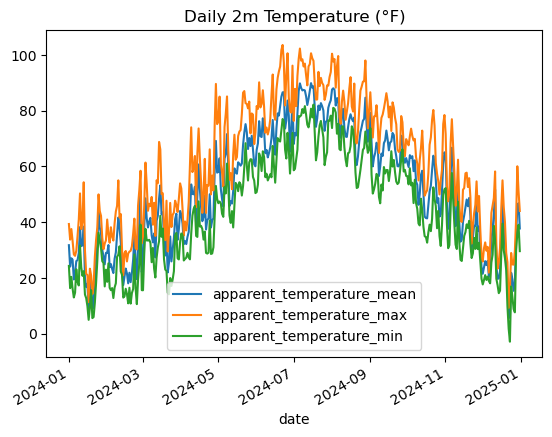

In [12]:
daily_df.plot(
    x = "date", 
    y = ["apparent_temperature_mean", "apparent_temperature_max", "apparent_temperature_min"], 
    title = "Daily 2m Temperature (°F)"
)
plt.show()

In [13]:
daily_df["apparent_temperature_max"].max()

103.5813980102539